# Single Cell Sequencing: gene discovery exploration

Here we explore the traspose matrix, meaning how genes are close to each other. 

The idea is to explore genes that have similar expression, ergo could have similar funcionality (gene discovery procesure).

For that aim, we normalize each gene counting among cells between 0 and 1, and we reduce the dimensinality using umap transformation. Later we measure distance in the umap space (also could be done in the original space).

For measuring distance at first instance we are using euclidean distance. We have to explore different measures for similarity to check results and expand to other possibles genes. 

First part of the notebook is repreting the matrix agregation and quality control, then we start with gene discovery exploration analysis. 

In [1]:
!pip install --quiet anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import anndata as ad
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import os 
#doublet detection
import scrublet as scr
#batch correction (not installed by default in the docker container, install via command line: pip install scanorama bbknn)
import scanorama as scan
#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb
import sys 
sb.set_context(context='poster')

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

2023-09-01 13:54:42.881333: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 13:54:42.979341: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-01 13:54:42.979357: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-01 13:54:43.502614: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

scanpy==1.9.2 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.9.2 pandas==1.3.5 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.10.3 louvain==0.8.0 pynndescent==0.5.8


## SECTION I: Data loading, cell selection and data agregation

Here we declare file paths assuming fastq files had been already decompressed. 

We need adata file path (kallisto output), kept cell barcodes file (provided by scilife lab), 
all cell barcodes file (kallisto output), plate-cell barcode ID file (provided by scilife lab),
and flourecence information (file manually created with plate position info, flourence level, and our cell number).

This section loads all these files, and the final output is an anndata format count matrix with data agregation from all plates.

In [3]:
# load the unfiltered matrix and define all paths for storing data
figure_path = '/home/melma31/Documents/single_cell_sequencing/figures/'

results_file_sample1 = '/home/melma31/Documents/single_cell_sequencing/src/sample1/counts_unfiltered_umi/adata.h5ad'  # the file that will store the analysis results
results_file_sample2 = '/home/melma31/Documents/single_cell_sequencing/src/sample2/counts_unfiltered_umi/adata.h5ad'  # the file that will store the analysis results
results_file_sample3 = '/home/melma31/Documents/single_cell_sequencing/src/sample3/counts_unfiltered_umi/adata.h5ad'  # the file that will store the analysis results

#txt file with kept cells
cell_barcode_file_sample1 = '/home/melma31/Documents/single_cell_sequencing/SS3_22_291/zUMIs_output/SS3_22_291kept_barcodes.txt'
cell_barcode_file_sample2 = '/home/melma31/Documents/single_cell_sequencing/SS3_23_049/zUMIs_output/SS3_23_049kept_barcodes.txt'
cell_barcode_file_sample3 = '/home/melma31/Documents/single_cell_sequencing/SS3_23_127/zUMIs_output/SS3_23_127kept_barcodes.txt'

#read barcodes with kalisto
cell_barcode_file_new_sample1 = '/home/melma31/Documents/single_cell_sequencing/src/sample1/counts_unfiltered_umi/cells_x_genes.barcodes.txt'
cell_barcode_file_new_sample2 = '/home/melma31/Documents/single_cell_sequencing/src/sample2/counts_unfiltered_umi/cells_x_genes.barcodes.txt'
cell_barcode_file_new_sample3 = '/home/melma31/Documents/single_cell_sequencing/src/sample3/counts_unfiltered_umi/cells_x_genes.barcodes.txt'

#txt file with well barcodes. the text contains the cell barcode corresponding to each position in the plate
well_barcode_sample1 = '/home/melma31/Documents/single_cell_sequencing/SS3_22_291/zUMIs_output/stats/SS3_22_291.well_barcodes.txt'
well_barcode_sample2 = '/home/melma31/Documents/single_cell_sequencing/SS3_23_049/zUMIs_output/stats/SS3_23_049.well_barcodes.txt'
well_barcode_sample3 = '/home/melma31/Documents/single_cell_sequencing/SS3_23_127/zUMIs_output/stats/SS3_23_127.well_barcodes.txt'

###upload excel with red and green flourecence from campari (has information about position in plate and fluorecence level)
florecence_1_file_path = '/home/melma31/Documents/single_cell_sequencing/data/well_1_data_base.csv'
florecence_2_file_path = '/home/melma31/Documents/single_cell_sequencing/data/well_2_data_base.csv'
florecence_3_file_path = '/home/melma31/Documents/single_cell_sequencing/data/well_3_data_base.csv'

In [4]:
### load raw adata file using adata libraty
sample1 = ad.read_h5ad(results_file_sample1)
sample2 = ad.read_h5ad(results_file_sample2)
sample3 = ad.read_h5ad(results_file_sample3)

### read fluorecence levels
flourecence1 = pd.read_csv(florecence_1_file_path)
flourecence2 = pd.read_csv(florecence_2_file_path)
flourecence3 = pd.read_csv(florecence_3_file_path)

### read kept barcodes and barcodes provided by kalisto
df_1_sample1 = pd.read_csv(cell_barcode_file_sample1, delimiter = "\,")
df_2_sample1 = pd.read_csv(cell_barcode_file_new_sample1)

df_1_sample2 = pd.read_csv(cell_barcode_file_sample2, delimiter = "\,")
df_2_sample2 = pd.read_csv(cell_barcode_file_new_sample2)

df_1_sample3 = pd.read_csv(cell_barcode_file_sample3, delimiter = "\,")
df_2_sample3 = pd.read_csv(cell_barcode_file_new_sample3)

### merge data base. Merge information about cell barcode and fluorecence 
### (using as common demonimator the position in the plate)
barcode_list_sample1 = list(df_1_sample1['XC'])
well_df_sample1 = pd.read_csv(well_barcode_sample1, delimiter = "\t")
mergedRes1 = pd.merge(well_df_sample1 , flourecence1, on ='well_id')

barcode_list_sample2 = list(df_1_sample2['XC'])
well_df_sample2 = pd.read_csv(well_barcode_sample2, delimiter = "\t")
mergedRes2 = pd.merge(well_df_sample2 , flourecence2, on ='well_id')

barcode_list_sample3 = list(df_1_sample3['XC'])
well_df_sample3 = pd.read_csv(well_barcode_sample3, delimiter = "\t")
mergedRes3 = pd.merge(well_df_sample3 , flourecence3, on ='well_id')

/home/melma31/mambaforge/lib/python3.10/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [5]:
def barcode_check(df_1,df_2,barcode_list,mergedRes):

    #print(barcode_list)
    kept_cells = np.zeros((len(df_1),))
    well_id = np.zeros((len(df_1),))

    red_f = np.zeros((len(df_1),))
    green_f = np.zeros((len(df_1),))
    stimulus = np.zeros((len(df_1),))

    index_vector = np.zeros((len(df_1),))
    count = 0
    counter = 0
    for i in range(len(df_2)):
        x = df_2.iloc[i]['Barcodes']
        if x in barcode_list:
            index = barcode_list.index(x)
            index_vector[count] = index
            if len(np.where(np.isnan(mergedRes['stimulus'].where(mergedRes['bc_set'] == x))==False)):
                counter+=1
                position = np.where(np.isnan(mergedRes['stimulus'].where(mergedRes['bc_set'] == x))==False)[0][0]
                stimulus[index] = mergedRes['stimulus'].where(mergedRes['bc_set'] == x)[position]
                red_f[index] = mergedRes['red_f'].where(mergedRes['bc_set'] == x)[position]
                green_f[index] = mergedRes['green_f'].where(mergedRes['bc_set'] == x)[position]
                kept_cells[index] = int(i)
                well_id[index] = 1
                count +=1
    #kept_cells = np.unique(kept_cells)
    count = len(df_1)
    
    return kept_cells, well_id,stimulus,red_f,green_f


In [6]:
kept_cells1, well_id1,stimulus_1,red_f1,green_f1 = barcode_check(df_1_sample1,df_2_sample1,barcode_list_sample1,mergedRes1)
kept_cells2, well_id2,stimulus_2,red_f2,green_f2 = barcode_check(df_1_sample2,df_2_sample2,barcode_list_sample2,mergedRes2)
kept_cells3, well_id3,stimulus_3,red_f3,green_f3 = barcode_check(df_1_sample3,df_2_sample3,barcode_list_sample3,mergedRes3)


In [7]:
### select only kept cells
adata1 = sample1[kept_cells1.astype(int),:]
adata2 = sample2[kept_cells2.astype(int),:]
adata3 = sample3[kept_cells3.astype(int),:]


### add campari information to adata structure
adata1.obs['stimulus'] = stimulus_1 
adata1.obs['red'] = red_f1
adata1.obs['green'] = green_f1
adata1.obs['well_id'] = well_id1

adata2.obs['stimulus'] = stimulus_2
adata2.obs['red'] = red_f2
adata2.obs['green'] = green_f2
adata2.obs['well_id'] = well_id2


adata3.obs['stimulus'] = stimulus_3
adata3.obs['red'] = red_f3
adata3.obs['green'] = green_f3
adata3.obs['well_id'] = well_id3


### data integration

adata_1 = adata1.concatenate(adata2, join='outer', batch_categories=['sample1', 'sample2'], index_unique='-')
adata = adata_1.concatenate(adata3, join='outer', batch_categories=['sample12', 'sample3'], index_unique='-')

print('Number of cells:', adata.X.shape[0])
print('Number of genes:', adata.X.shape[1])

/tmp/ipykernel_84805/2144263004.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata1.obs['stimulus'] = stimulus_1
/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_84805/2144263004.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata2.obs['stimulus'] = stimulus_2
/tmp/ipykernel_84805/2144263004.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata3.obs['stimulus'] = stimulus_3
/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly t

Number of cells: 1152
Number of genes: 55421


## SECTION II: Quality control

In [8]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(axis = 1)
x =  adata.X.sum(axis = 1)
adata.obs['log_counts'] = np.log(x)
adata.obs['n_genes'] = (adata.X > 0).sum(axis = 1)

In [9]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [10]:
mt_gene_mask = np.flatnonzero([gene.startswith('mt-') for gene in adata.var_names])
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
y = np.sum(adata[:, mt_gene_mask].X, axis=1).A1.reshape(-1,)
z = np.array(adata.obs['n_counts']).reshape(-1,)
adata.obs['mt_frac'] = y/z

normalizing counts per cell
    finished (0:00:00)


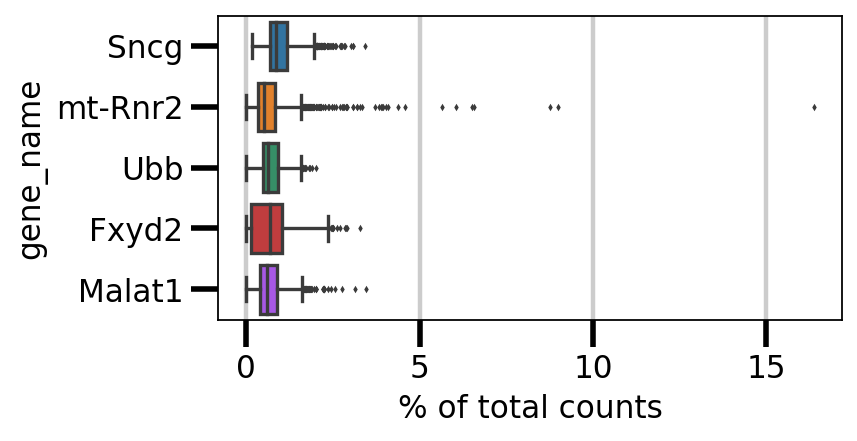

In [11]:
adata.var["gene_id"] = adata.var.index.values

t2g = pd.read_csv("t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
t2g.index = t2g.gene_id
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

adata.var["gene_name"] = adata.var.gene_id.map(t2g["gene_name"])
adata.var.index = adata.var["gene_name"]

sc.pl.highest_expr_genes(adata, n_top=5)

adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

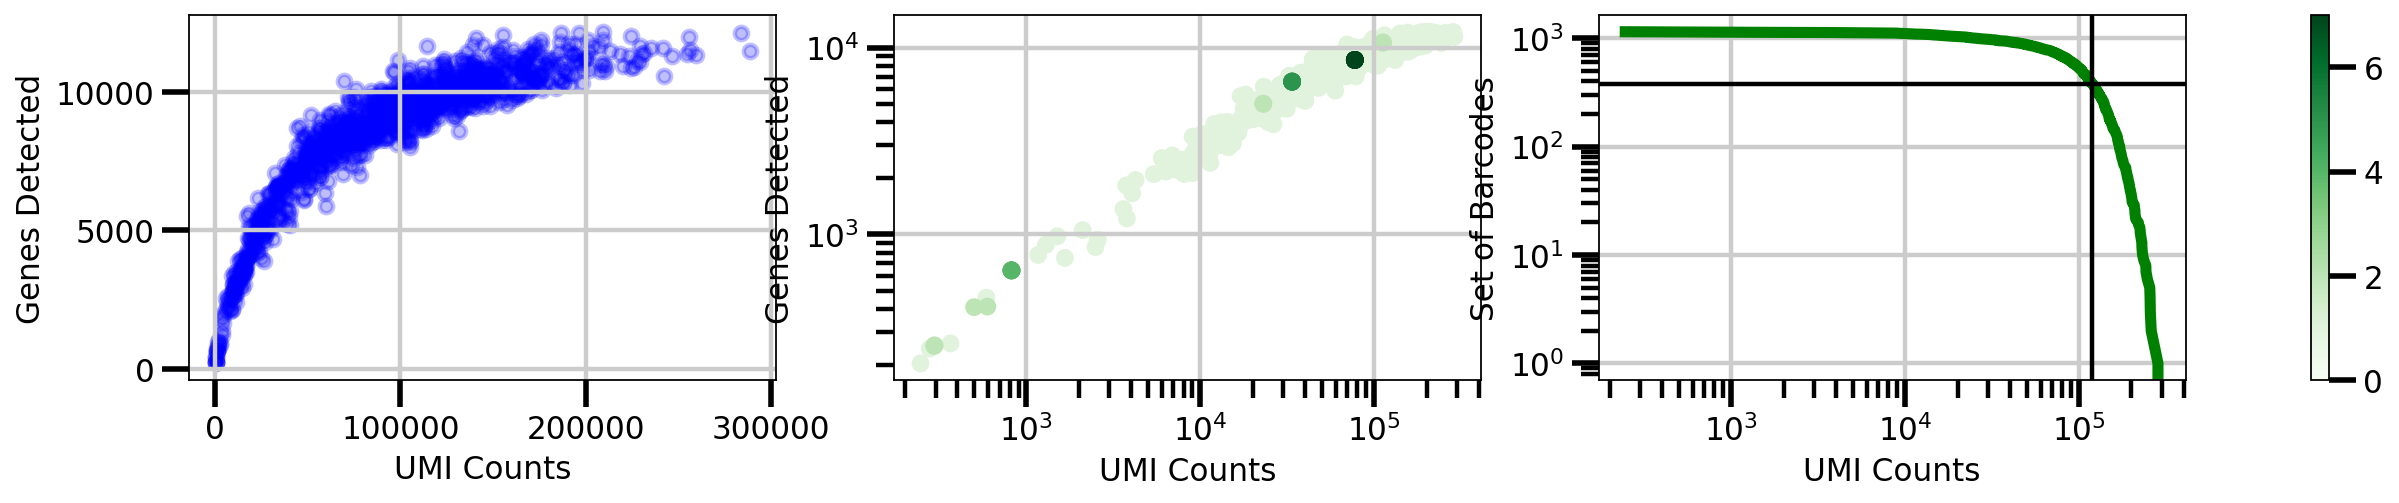

In [12]:
#Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(1,3)
x = np.asarray(adata.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]
ax[0].scatter(x, y, color="b", alpha=0.25)
ax[0].set_ylabel("Genes Detected")
ax[0].set_xlabel("UMI Counts")
#ax.set_xscale('log')
#ax.set_yscale('log')

#histogram definition
bins = [1500, 1500] # number of bins
# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)
# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

s = ax[1].scatter(x2, y2, c=z2, cmap='Greens')  
fig.colorbar(s, ax=ax)

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel("UMI Counts")
ax[1].set_ylabel("Genes Detected")


expected_num_cells =  380#@param {type:"integer"}
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

ax[2].loglog(knee, range(len(knee)), linewidth=5, color="g")
ax[2].axvline(x=knee[expected_num_cells], linewidth=2, color="k")
ax[2].axhline(y=expected_num_cells, linewidth=2, color="k")

ax[2].set_xlabel("UMI Counts")
ax[2].set_ylabel("Set of Barcodes")

#plt.grid(True, which="both")

fig.set_size_inches([20,3])
plt.show()
fig.savefig(figure_path + 'QC_UMI_genes_counts.png')

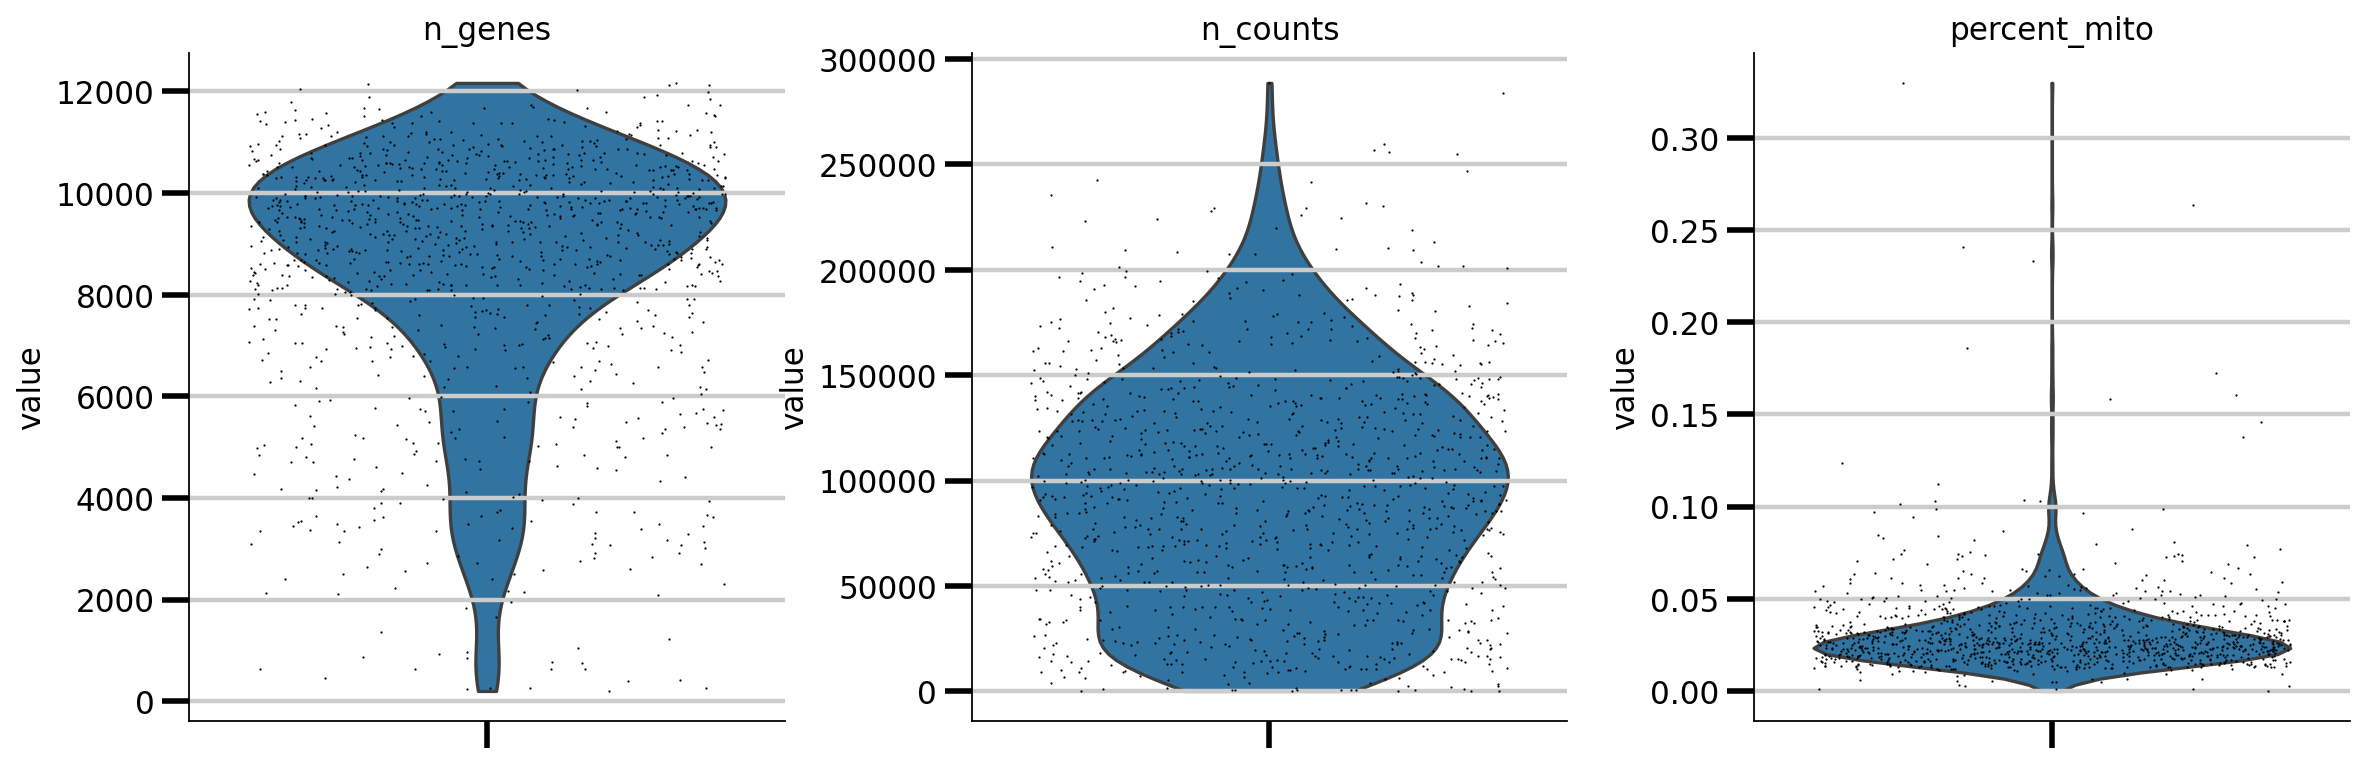

In [13]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
### check for mitochandrial mRNA
mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

In [14]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))
#cell_subset = sc.pp.filter_cells(adata, min_counts = 1000)
#filter1 = kept_cells_stimuli[cell_subset[0]]
#red_filter1 = red_intensity[cell_subset[0]]
#green_filter1 = green_intensity[cell_subset[0]]
#well_id_filter1 = well_id[cell_subset[0]]
sc.pp.filter_cells(adata, min_counts = 1000)

Total number of cells: 1152
filtered out 12 cells that have less than 1000 counts


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [15]:
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))
#cell_subset = sc.pp.filter_cells(adata, min_genes = 1000,inplace=False)
#filter2 = filter1[cell_subset[0]]
#red_filter2 = red_filter1[cell_subset[0]]
#green_filter2 = green_filter1[cell_subset[0]]
#well_id_filter2 = well_id_filter1[cell_subset[0]]
sc.pp.filter_cells(adata, min_genes = 1000)

Number of cells after min count filter: 1140
filtered out 6 cells that have less than 1000 genes expressed


In [16]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))
# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=5)
#sc.pp.filter_genes(adata, min_counts=10)


Total number of genes: 55421
filtered out 29491 genes that are detected in less than 5 cells


In [17]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
print(adata.shape)

(1134, 25930)


## SECTION III: Analysis for gene discovery


In [29]:
labels=['Control','pinch','new_stroke','ballon','AG','AD','heating','mock','old_stroke','anal_pinch','mock_w_poop','vaginal_distension','tomatoe','poop']

sc.pp.normalize_total(adata, target_sum=1e4)

x = scipy.sparse.csr_matrix.toarray(adata.X)
stim = np.zeros((x.shape[0],))
red = np.zeros((x.shape[0],))
green = np.zeros((x.shape[0],))
louvain = np.zeros((x.shape[0],6))

for i in range(x.shape[0]):
    stim[i] = adata.obs['stimulus'][i]
    red[i] = adata.obs['red'][i]
    green[i] = adata.obs['green'][i]

normalizing counts per cell
    finished (0:00:00)


In [41]:
### create a umap embedding in the genes x genes space

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap

scaled_data = StandardScaler().fit_transform(x)
scaled_data = (scaled_data.T - np.min(scaled_data, axis = 1))/ (np.max(scaled_data, axis = 1).reshape(-1) - np.min(scaled_data, axis = 1).reshape(-1))

number_of_components = 25
pca1 = PCA(number_of_components)
pca1.fit(scaled_data)
pca_embedding = pca1.transform(scaled_data)
reducer = umap.UMAP(n_components = 2)
umap_embedding = reducer.fit_transform(pca_embedding)

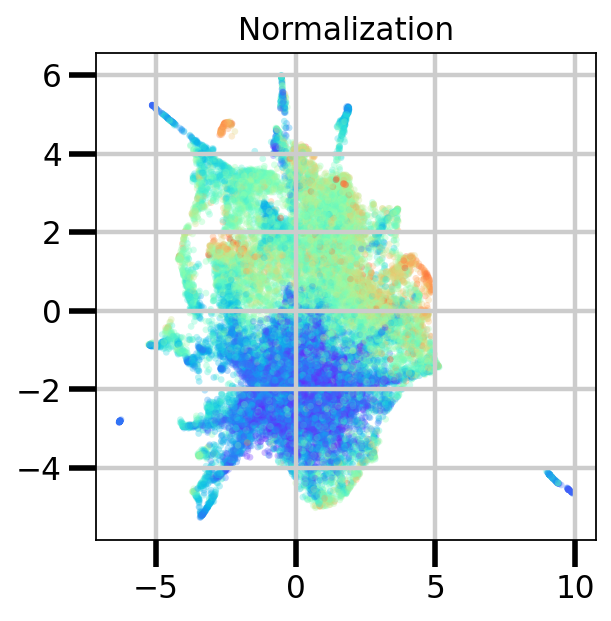

In [43]:

figure, axes = plt.subplots(1,1)
expression_count = np.sum(x.T,axis = 1)
axes.scatter(umap_embedding[:,0],umap_embedding[:,1], s= 1,alpha = 0.3, c = np.log(expression_count), cmap = 'rainbow')

axes.set_title('Normalization')
figure.savefig(figure_path + 'genes_umap_expression_normed_campari.png')

In [49]:
gene_name = []
for i in range(len(adata.var['gene_name'])):
    gene_name.append(adata.var['gene_name'].iloc[i])

    
marker_genes = ['Ntrk2','Cd34','Nppb','Mrgprb4','Mrgpra3','Mrgprd','Sstr2','Adra2a','Smr2',
                'Bmpr1b','Nefh','Pvalb','Adm',
                'Trpm3','Piezo2','Trpm2','Smr2','Sstr2','Bmpr1b','Trpm8','Trpv1','Piezo2','Piezo1','Nppb',
                'Sst','Pvalb','Prokr2','Mrgprd','Mrgpra3','Cd34',
                'Th','Trpa1','Ntrk3','Ntrk2','Ntrk1','Ret','Tac1','Calca','Calcb','Nefh',
                'S100b','Scn10a','Slc17a8','Atf3','Pou4f3','Calb1','Avil','Asic3',
                'Asic2','Asic1','Pou6f2','Avpr1a','Pou4f2','Sox10','Chrna7','Chrna3',
                'P2rx3','Gfra2','Ldhb','Necab2','Spp1','Adra2a','Chrna7','Tafa4']

marker_position = np.zeros((len(marker_genes),))
count = 0
for marker in  marker_genes:
    index = gene_name.index(marker)
    marker_position[count] = index
    count = count+1

n = 20
nearest_neighbors = np.zeros((n, len(marker_genes)))
nearest_neighbors_distance = np.zeros((n, len(marker_genes)))
auxiliar_distance = np.zeros((umap_embedding.shape[0]))

nearest_neighbors_cut = np.zeros((n, len(marker_genes)))
nearest_neighbors_distance_cut = np.zeros((n, len(marker_genes)))
auxiliar_distance_cut = np.zeros((umap_embedding.shape[0]))

for i in range(len(marker_genes)):
    a = umap_embedding[int(marker_position[i]),:]
    #a = x.T[int(marker_position[i]),:]
    for j in range(umap_embedding.shape[0]):
        b = umap_embedding[j,:]
        #b = x.T[j,:]
        dist = np.linalg.norm(a-b)
        auxiliar_distance[j] = dist
    sorted_arguments = np.argsort(auxiliar_distance)
    nearest_neighbors_distance[:,i] = auxiliar_distance[sorted_arguments[0:n]]
    nearest_neighbors[:,i] = sorted_arguments[0:n].astype(int)

    
closest_genes = []
for i in range(len(marker_genes)):
    closest_genes_ = []
    for j in range(n):
        closest_genes_.append(gene_name[int(nearest_neighbors[j,i])])
    closest_genes.append(closest_genes_)
 

In [52]:
#############################################################################################################
#############################################################################################################
#############################################################################################################
#################### HERE WE EXPORT ALL THE INFORMATION FOR GENES AS .MAT ################

data = {'umap_embedding_norm': umap_embedding,'genes': gene_name}
scipy.io.savemat(figure_path + 'genes_umap_1.mat', data)        

#############################################################################################################
#############################################################################################################
#############################################################################################################

9857.0